In [ ]:
!pip install pennylane==0.33.1 pennylane-qiskit==0.33.1 memory-profiler line-profiler

INFO: pip is looking at multiple versions of pennylane-lightning to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 717.6/717.6 kB 30.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.0/930.0 kB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.1/18.1 MB 35.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 52.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 41.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 28.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.9/249.9 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 39.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 340.8/340.8

0.91015625
(<Figure size 5700x2100 with 1 Axes>, <Axes: >)


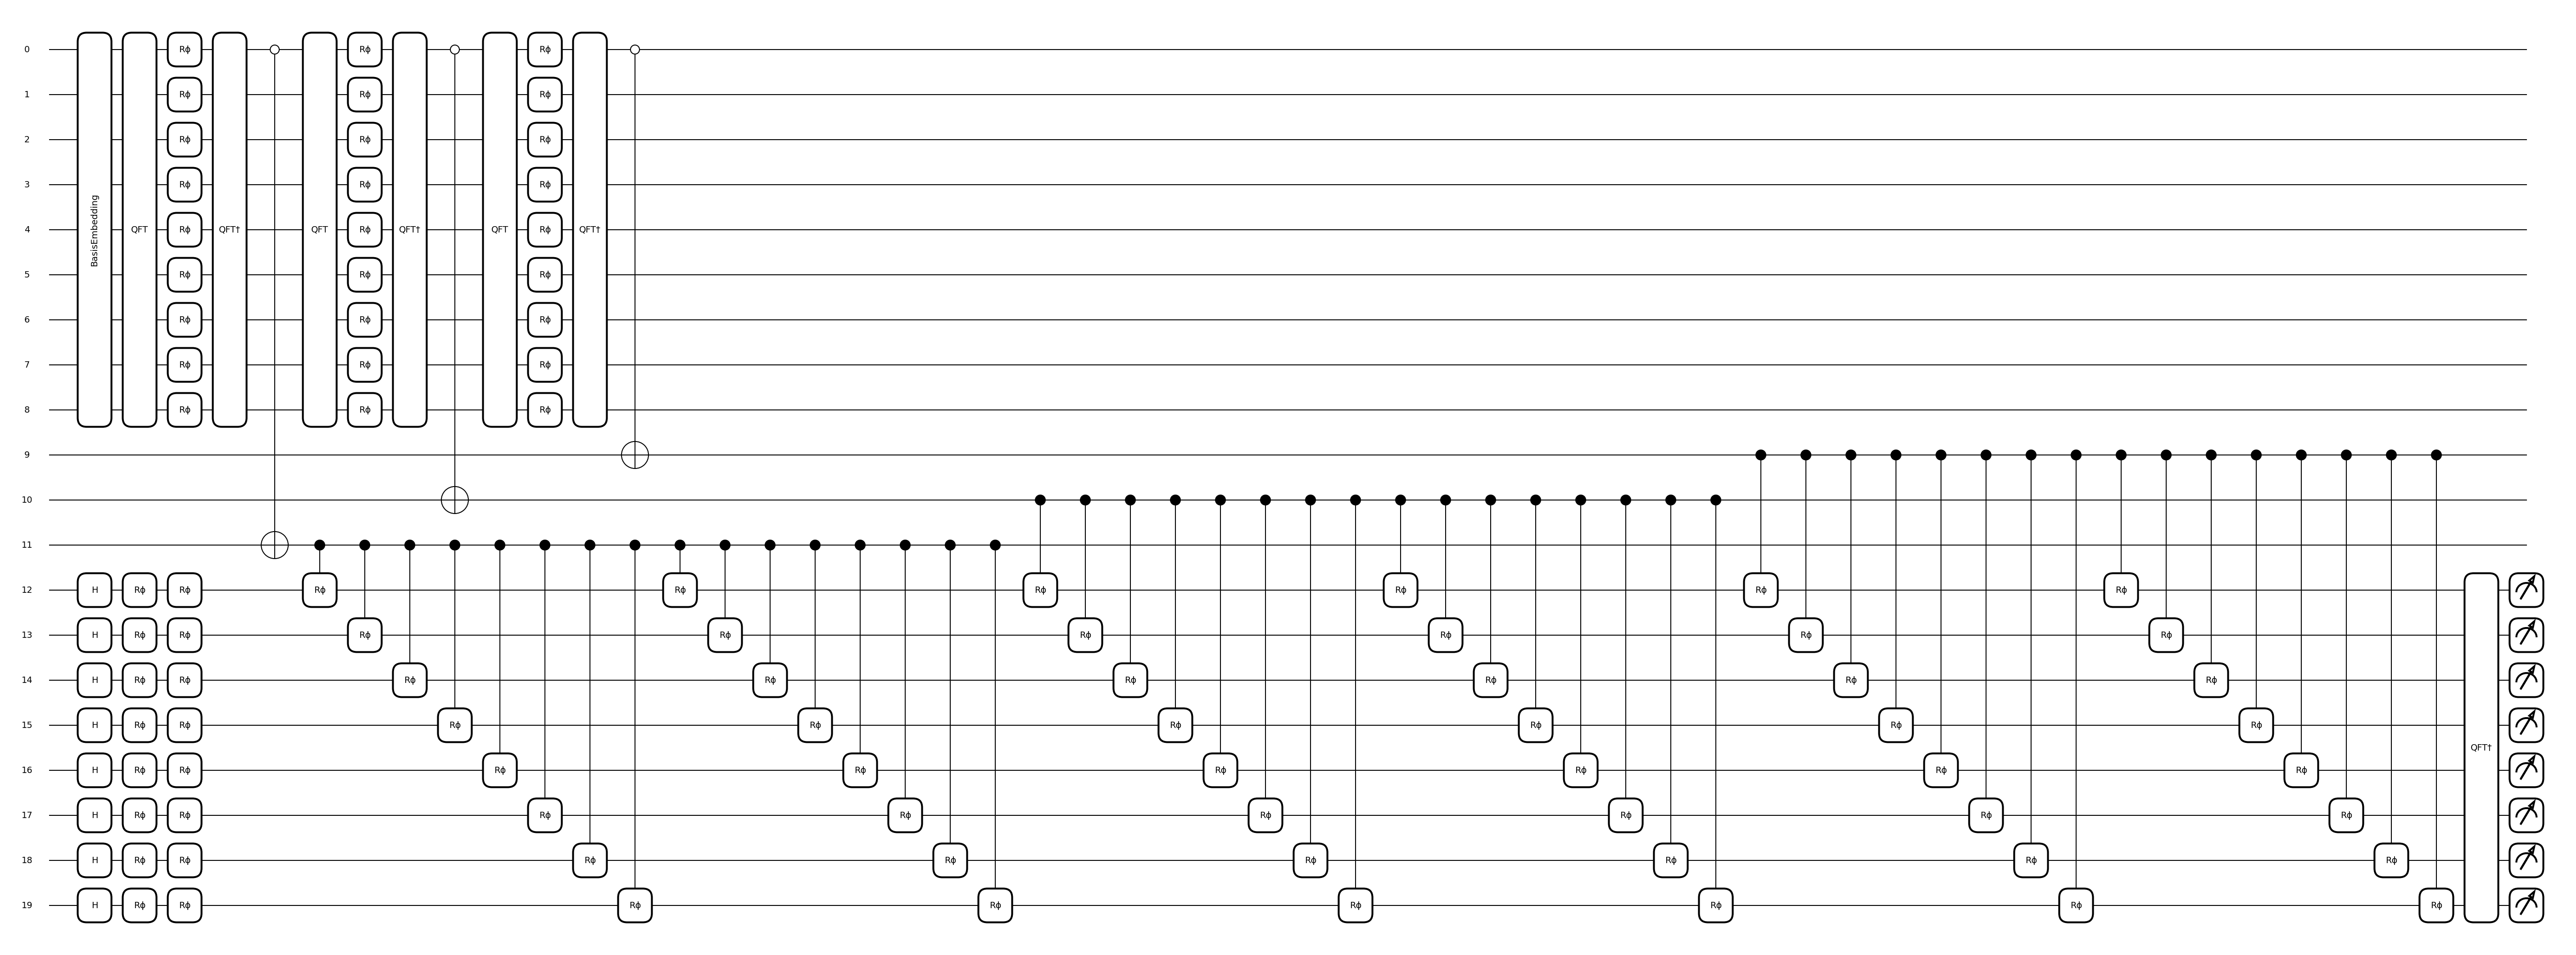

In [ ]:
import math
import pennylane as qml
import pennylane.numpy as np

# MODIFY THESE CONSTANTS AS DESIRED

EXPONENT_QUBITS = 8
SOLUTION_QUBITS = 8
NUM_COMPARISONS = 3

# DO NOT MODIFY THESE CONSTANTS

a = 1 + EXPONENT_QUBITS # Adds an extra qubit to handle float 0 case,
                        # since attempting to subtract from exponent -126
                        # will create overflow and mess up the comparisons.
b = a + NUM_COMPARISONS
c = b + SOLUTION_QUBITS

wires_exponent = list(range(0, a))
wires_compare  = list(range(a, b))
wires_solution = list(range(b, c))
wires_total    = wires_exponent + wires_compare + wires_solution

dev = qml.device("ionq.simulator", api_key="WAUL3EgxQmFvYSB52uDAMgHg1Du9HmtH", wires=wires_m  + wires_solution, shots=1)

def prepare_zero_QFT_state(wires):
  for wire in wires:
    qml.Hadamard(wires = [wire])

def add(x, accumulator_wires):
  for wire in range(len(accumulator_wires)):
    qml.PhaseShift(np.pi * x * (2 ** -wire), wires = [accumulator_wires[wire]])

last_comparison = 0

def comparison(x, sign_wire):
  global last_comparison
  x += 127 # Add the exponent bias
  qml.QFT(wires = wires_exponent)
  add(last_comparison - x, wires_exponent)
  last_comparison = x
  qml.adjoint(qml.QFT)(wires = wires_exponent)
  qml.ctrl(qml.PauliX, wires_exponent[0], control_values = 0)(wires = [sign_wire])
  last_comparison_wire = sign_wire

def add_linear_function(x, slope, intercept, ctrl = None, sign = 1):
  offset = 2 ** SOLUTION_QUBITS
  constant_phase = offset * sign * intercept
  variable_phase = offset * slope * x
  ctrl_add = add if ctrl is None else qml.ctrl(add, control = [ctrl])
  ctrl_add(variable_phase, wires_solution)
  ctrl_add(constant_phase, wires_solution)

@qml.qnode(dev)
def quantum_sigmoid(x):
  _, exponent = math.frexp(x)
  sign = 1 if x >= 0 else -1
  exponent += 126 # Simulate the bias of passing in an actual float exponent
  if x == 0: exponent = -126 # IEEE74 exponent for 0 is -126
  #########################################################################
  qml.BasisEmbedding(exponent, wires = wires_exponent)
  prepare_zero_QFT_state(wires_solution)
  #########################################################################
  add_linear_function(x, 0.231, 0.500)
  #########################################################################
  comparison(0, wires_compare[2]) # Check if |x| >= 1 (exponent - 127 >= 0)
  add_linear_function(x, -0.081, 0.081, wires_compare[2], sign)
  #########################################################################
  comparison(1, wires_compare[1]) # Check if |x| >= 2 (exponent - 127 >= 1)
  add_linear_function(x, -0.099, 0.198, wires_compare[1], sign)
  #########################################################################
  # This part seems to cause some decoherence issues for small numbers,
  # and makes it so that the function cannot be repeatedly called.
  # For -4 <= x <= 4, this segment can be entirely removed.
  comparison(2, wires_compare[0]) # Check if |x| >= 4 (exponent - 127 >= 2)
  add_linear_function(x, -0.051, 0.204, wires_compare[0], sign)
  #########################################################################
  qml.adjoint(qml.QFT)(wires = wires_solution)
  return qml.sample(wires = wires_solution)

def sigmoid(x):
  return int(''.join([str(y) for y in quantum_sigmoid(x)]), 2) * (2 ** -SOLUTION_QUBITS)

print(sigmoid(2.3)) # Actual sigmoid value is 0.909
print(qml.draw_mpl(quantum_sigmoid)(0))